# Traffic sign classification

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pandas as pd
import pickle

# Load up the augmented training datasign_names = pd.read_csv('signnames.csv')
training_file = 'augmented_train.p'
validation_file='../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['X_train'], train['y_train']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
sign_names = pd.read_csv('signnames.csv')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Helper functions
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

def flatten_conv(x, input_shape, output_len):
    if input_shape[0] * input_shape[1] * input_shape[2] - output_len:
        raise Exception('Input and output shape mismatch while flattening')
    return flatten(x)

def fc_relu(x, input_len, output_len):
    _fc = fc(x, input_len, output_len)
    return  tf.nn.relu(_fc)

def fc(x, input_len, output_len):
    fc_W  = tf.Variable(tf.truncated_normal(shape=(input_len, output_len), mean = mu, stddev = sigma))
    fc_b  = tf.Variable(tf.zeros(output_len))
    _fc    = tf.matmul(x, fc_W) + fc_b
    return _fc

def max_pool(x, input_shape, output_shape, kernel_width=2, stride=2):
    input_width = input_shape[0]
    output_width = output_shape[0]
    if input_width/2 == output_width:
        return tf.nn.max_pool(x, ksize=[1, kernel_width, kernel_width, 1], strides=[1, stride, stride, 1], padding='VALID')
    elif input_width == output_width:
        return tf.nn.max_pool(x, ksize=[1, kernel_width, kernel_width, 1], strides=[1, 1, 1, 1], padding='SAME')

def conv2d_relu(x, input_shape, output_shape, kernel_width = 5, strides=[1, 1, 1, 1]):
    """
    Define a standard convolution layer with relu activation
    """
    input_width = input_shape[0]
    input_depth = input_shape[2]
    output_width = output_shape[0]
    kernel_depth = output_shape[2]
    if output_width % 2:
        raise Exception('Output shape is odd. Not supported at the moment')
    elif  input_shape[0]!= input_shape[1] or output_shape[0]!= output_shape[1]:
        raise Exception('Only square images supported')
    if input_shape[0] == output_shape[0]:
        padding = 'SAME'
    elif input_shape[0] > output_shape[0]:
        padding = 'VALID'
        if input_width - output_width + 1 - kernel_width:
            raise Exception(
                'Kernel width of {} does not support {} - {} convolution'.format(
                    kernel_width,input_width,output_width))
    else:
        raise Exception('Output size is larger than input')

    conv_W = tf.Variable(tf.truncated_normal(shape=(kernel_width, kernel_width, input_depth, kernel_depth), mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(kernel_depth))
    conv = tf.nn.conv2d(x, conv_W, strides=strides, padding=padding) + conv_b
    return tf.nn.relu(conv)

# Model training

### Model Architecture

In [4]:
EPOCHS = 25
BATCH_SIZE = 128

In [5]:
def KNet(x):        
    # Convolutional layer #1
    h1 = conv2d_relu(x, input_shape=(32,32,3),output_shape=(32,32,5), kernel_width=3)
    h2 = max_pool(h1, input_shape = (32,32,5), output_shape=(32,32,5))
    #h = tf.nn.dropout(h, 0.5)

    # Convolutional layer #2
    h3 = conv2d_relu(h2, input_shape=(32,32,5),output_shape=(32,32,10), kernel_width=3)
    h4 = max_pool(h3, input_shape = (32,32,10), output_shape=(32,32,10))

    # Convolutional layer #3
    h5 = conv2d_relu(h4, input_shape=(32,32,10),output_shape=(32,32,20), kernel_width=3)
    h6 = max_pool(h5, input_shape = (32,32,20), output_shape=(32,32,20))
    h7 = tf.nn.dropout(h6, 0.5)

    # Convolutional layer #4
    h8 = conv2d_relu(h7, input_shape=(32,32,20), output_shape=(28,28,25), kernel_width=5)
    h9 = max_pool(h8, input_shape = (28,28,25), output_shape=(14,14,25))

    # Convolutional layer #5
    h10 = conv2d_relu(h9, input_shape=(14,14,25), output_shape=(10,10,30), kernel_width=5)
    h11 = max_pool(h10, input_shape = (10,10,30), output_shape=(5,5,30))
    #h = tf.nn.dropout(h, 0.5)

    # Flatten convolution
    h12   = flatten_conv(h11, input_shape=(5,5,30), output_len=750)
    
    # Fully connected layers
    h13 = fc_relu(h12, input_len=750, output_len=43)
    h14 = fc(h13, input_len=43, output_len=43)

    return h14

### Train, Validate and Test the Model

In [6]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
is_training = tf.placeholder(tf.bool, True)
one_hot_y = tf.one_hot(y, 43)
rate = tf.placeholder(tf.float32, [])
logits = KNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [7]:
training_info = []
learning_rate = 0.001
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, rate:learning_rate})
            
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        if i and i%10 == 0:
            learning_rate = learning_rate/2 
        training_info.append({
            'training_accuracy': training_accuracy,
            'validation_accuracy': validation_accuracy,
            'learning_rate': learning_rate,
            'epoch': i
        })
    saver.save(sess, './knet_nov11')

Training...

EPOCH 1 ...
Training Accuracy = 0.791
Validation Accuracy = 0.778

EPOCH 2 ...
Training Accuracy = 0.913
Validation Accuracy = 0.878

EPOCH 3 ...
Training Accuracy = 0.954
Validation Accuracy = 0.918

EPOCH 4 ...
Training Accuracy = 0.968
Validation Accuracy = 0.933

EPOCH 5 ...
Training Accuracy = 0.975
Validation Accuracy = 0.937

EPOCH 6 ...
Training Accuracy = 0.977
Validation Accuracy = 0.941

EPOCH 7 ...
Training Accuracy = 0.984
Validation Accuracy = 0.942

EPOCH 8 ...
Training Accuracy = 0.981
Validation Accuracy = 0.942

EPOCH 9 ...
Training Accuracy = 0.980
Validation Accuracy = 0.937

EPOCH 10 ...
Training Accuracy = 0.984
Validation Accuracy = 0.942

EPOCH 11 ...
Training Accuracy = 0.988
Validation Accuracy = 0.949

EPOCH 12 ...
Training Accuracy = 0.995
Validation Accuracy = 0.956

EPOCH 13 ...
Training Accuracy = 0.995
Validation Accuracy = 0.959

EPOCH 14 ...
Training Accuracy = 0.995
Validation Accuracy = 0.958

EPOCH 15 ...
Training Accuracy = 0.993
Valid

In [8]:
training_info_df = pd.DataFrame(training_info)

In [9]:
# Final training and validation accuracy
training_info_df[::-1].head(1)

,epoch,learning_rate,training_accuracy,validation_accuracy
24,24,0.00025,0.99735,0.961451


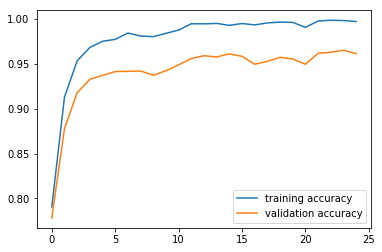

In [11]:
%matplotlib inline
plt.plot(training_info_df['epoch'], training_info_df['training_accuracy'])
plt.plot(training_info_df['epoch'], training_info_df['validation_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])

This model has a training accuracy of 99.7 % and a validation accuracy of 96.1 %